# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd 
import numpy as np
import tweepy
import glob
import requests
import os
import seaborn as sb
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import json 
import PIL.Image
from io import BytesIO
from PIL import Image

In [2]:
df_archive= pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
import requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url, allow_redirects=True)

In [4]:
open('image_predictions.tsv', 'wb').write(response.content)

335079

In [5]:
df_image = pd.read_csv('image_predictions.tsv', sep = '\t')
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

## i can't create developer ccount on twiter , so i write the code dut don't use it & read data from tweet-json.txt

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

consumer_key = 'Smagdy7_MYN'
consumer_secret = 'Nelly'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df_archive.tweet_id.values
len(tweet_ids)

count = 0
fails_dict = {}
start = timer()
#Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer(print(end - start))
print(fails_dict)

## read data from tweet-json.txt 

In [6]:
tweet_status_df = pd.read_json('tweet-json.txt', lines = True,encoding='utf-8')

In [7]:
tweet_status_df

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [8]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [9]:
df_image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [10]:
tweet_status_df

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [11]:
df_archive.shape

(2356, 17)

In [12]:
df_image.shape

(2075, 12)

In [13]:
tweet_status_df.shape

(2354, 31)

In [14]:
#check datatype and columns number and names
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
#get data statistics
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [16]:
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
858,763837565564780549,NaN,NaN,2016-08-11 20:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Alfie. He's touching a butt. Couldn't ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/763837565...,11,10,Alfie,None,None,None,None
2098,670727704916926465,NaN,NaN,2015-11-28 22:15:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeffrie. He's a handheld pup. Excellen...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670727704...,10,10,Jeffrie,None,None,None,None
817,770772759874076672,NaN,NaN,2016-08-30 23:58:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sebastian. He's super h*ckin fluffy. T...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770772759...,11,10,Sebastian,None,None,None,None
1187,718460005985447936,NaN,NaN,2016-04-08 15:26:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Bowie. He's listening for underground squ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718460005...,9,10,Bowie,None,None,None,None
83,876537666061221889,NaN,NaN,2017-06-18 20:30:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can say with the pupmost confidence that the...,NaN,NaN,NaN,https://twitter.com/mpstowerham/status/8761629...,14,10,None,None,None,None,None


In [17]:
#check duplicate data for tweet_id 
df_archive.tweet_id.duplicated().sum()

0

In [18]:
# check denominator sholud be 10
df_archive[df_archive['rating_denominator'] >10 ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


In [19]:
# mistyping for rate  numerator
df_archive[df_archive['rating_numerator'] >20 ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [20]:
# check names value count
df_archive['name'].value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
the            8
Sadie          8
an             7
Daisy          7
Buddy          7
Bailey         7
Toby           7
Oscar          6
Bella          6
Scout          6
Jack           6
Stanley        6
Rusty          6
Milo           6
Dave           6
Koda           6
Jax            6
Leo            6
Louis          5
            ... 
Ashleigh       1
Norman         1
Deacon         1
Lance          1
Aldrick        1
Jeb            1
Siba           1
Dotsy          1
Strudel        1
Ivar           1
Acro           1
Coopson        1
Joshwa         1
Roscoe         1
Jebberson      1
Pete           1
Stormy         1
Goliath        1
Harvey         1
Dale           1
Bookstore      1
Toffee         1
O              1
Dewey          1
Peanut         1
Godi           1
Cuddles        1
Schnozz       

In [21]:
#check columns name
list(df_archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [22]:
## check column 'name' have letter not name
df_archive[df_archive.name=='a']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None
1207,715733265223708672,NaN,NaN,2016-04-01 02:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a taco. We only rate dogs. Please only...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715733265...,10,10,a,None,None,None,None
1340,704859558691414016,NaN,NaN,2016-03-02 02:43:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a heartbreaking scene of an incredible...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704859558...,10,10,a,None,None,pupper,None


In [23]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
df_image.shape

(2075, 12)

In [25]:
# Check duplicate tweet_id
df_image.tweet_id.duplicated().sum()

0

In [26]:
# check duplicate value @ jpg_url
df_image.jpg_url.duplicated().sum()

66

In [27]:
# counts of prediction 1 be dog
df_image['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [28]:
# counts of prediction 2 be dog
df_image['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [29]:
# counts of prediction 3 be dog
df_image['p3_dog'].value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [30]:
## sum of p2 False
(df_image.p2_dog==False).sum()

522

In [31]:
## sum of p3 False
(df_image.p3_dog==False).sum()

576

In [32]:
#check null image
df_image.img_num.isnull().sum()

0

In [33]:
tweet_status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [34]:
# count of retweet_status?
tweet_status_df['retweeted_status'].count()

179

In [35]:
# check duplicate id:

tweet_status_df.id.duplicated().sum()

0

In [36]:
#check samples
tweet_status_df.sample(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
2236,NaN,NaN,2015-11-21 17:05:31,"[0, 132]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 668113012746776577, 'id_str'...",709,False,This is Alfie. He's that one hypocritical gym ...,NaN,...,0.0,NaN,NaN,NaN,265,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
493,NaN,NaN,2016-12-26 01:00:05,"[0, 107]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 813187585275109376, 'id_str'...",22085,False,We only rate dogs. Please don't send in other ...,NaN,...,0.0,NaN,NaN,NaN,5096,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1518,NaN,NaN,2016-01-23 02:53:03,"[0, 108]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 690728920233218049, 'id_str'...",2384,False,This is Vinscent. He was just questioned about...,NaN,...,0.0,NaN,NaN,NaN,597,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1415,NaN,NaN,2016-02-13 16:50:04,"[0, 127]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 698549703420612608, 'id_str'...",2536,False,This is Claude. He's trying to be seductive bu...,NaN,...,0.0,NaN,NaN,NaN,704,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
863,NaN,NaN,2016-08-07 15:56:28,"[0, 61]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 762316483720511488, 'id_str'...",5350,False,This is Scout. He specializes in mid-air freez...,NaN,...,0.0,NaN,NaN,NaN,1298,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


### Quality issues

**twitter-archive-enhanced

1-'rating_denominator' columns standard 10

2-rating_numerator columns mistyping

3- Change 'None' to empty cell in doggo,floofer,pupper,puppo to add in dogs stage After that delete doggo,floofer,pupper,puppo columns

4-Rename for 'text' column

5-Delete unusual columns we will not use in analysis

6-Delete 'timestamp' column

7- Replace 'None' with NaN to indicate the missing values

8- keep original tweets (no retweets) that have images

9- The dog names format should be consistent. Make the first letter capital for all the names.

10-Column 'name' have error value 'a' should be correct or delete this value NaN

**Image Predictions

11- Drop duplicates values from jpg_url

12- The column names such as p1,p2 are not descriptive.

13- The prediction dog breeds involve both uppercase and lowercase for the first letter.

**Tweet JSON

14- Delete columns that won't be used for analysis

15-rename the column id to tweet_id

### Tidiness issues
#**twitter-archive-enhanced sheet:

1.Create dog stage column to put all type of dogs classification

2.-'timestamp' change from string to date format day, month , year columns and delete timestamp

3-Combine three different data frames into one master data set


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [37]:
# Make copies of original pieces of data
clean_archive=df_archive.copy()

### Issue #1:

#### Define:
Change 'None' to empty cell in doggo,floofer,pupper,puppo to add in dogs stage After that delete doggo,floofer,pupper,puppo columns

#### Code

In [38]:
#using for loop to fillter dogs stage
stage = ['doggo','pupper', 'floofer', 'puppo' ]
for i in stage:
       clean_archive[i] = clean_archive[i].replace('None', '')

In [39]:
# use cat to combine and  Create dog_stage to put all type of dogs classification
clean_archive['dog_stage'] = clean_archive.doggo.str.cat(clean_archive.floofer).str.cat(clean_archive.pupper).str.cat(clean_archive.puppo)

# drop the four old colomns
clean_archive = clean_archive.drop(['doggo','floofer','pupper','puppo'], axis = 1)

# use np.nan to fill the empty
clean_archive['dog_stage'] = clean_archive['dog_stage'].replace('', np.nan)

#### Test

In [40]:
#check sample data to confirm create dog_stage 
clean_archive.sample(5)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
854,765222098633691136,NaN,NaN,2016-08-15 16:22:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gromit. He's pupset because there's no...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765222098...,10,10,Gromit,NaN
268,841439858740625411,NaN,NaN,2017-03-14 00:04:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have some incredible doggos for #K9Vet...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/841439858...,14,10,None,NaN
1559,688547210804498433,NaN,NaN,2016-01-17 02:23:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Frönq. He got caught stealing a waffle...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688547210...,9,10,Frönq,NaN
1249,711306686208872448,NaN,NaN,2016-03-19 21:41:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",What hooligan sent in pictures w/out a dog in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/711306686...,3,10,None,NaN
353,831309418084069378,NaN,NaN,2017-02-14 01:09:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scooter and his son Montoya. Scooter ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831309418...,12,10,Scooter,NaN


### Issue #2:

#### Define:
'timestamp' change from string to date format day, month , year columns and delete timestamp

#### Code

In [41]:
 #convert timestamp to date format day, month , year 
clean_archive['timestamp'] = pd.to_datetime(clean_archive['timestamp'])

#extract year, month and day to new columns
clean_archive['year'] = clean_archive['timestamp'].dt.year
clean_archive['month'] = clean_archive['timestamp'].dt.month
clean_archive['weekday'] = clean_archive['timestamp'].dt.day_name()


#### Test

In [42]:
clean_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,year,month,weekday
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,2017,8,Tuesday
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,2017,8,Tuesday
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,2017,7,Monday
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,2017,7,Sunday
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,2017,7,Saturday


## Issue 3

**Define: delete timestamp column

In [43]:
#code:
# drop timestamp column
clean_archive = clean_archive.drop('timestamp', 1)

In [44]:
#test:
#list coloumn to confirm time stamp drop
list(clean_archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'year',
 'month',
 'weekday']

## Issue 4

-rating_denominator standard rate 10

In [45]:
# use for loop to set clean_archive.rating_denominator rate to 10

for x in clean_archive.rating_denominator:
    clean_archive.rating_denominator=10.0

In [46]:
#test total rating_denominator
sum(clean_archive.rating_denominator>10)

0

## Issue 5 
correct rate for rating_numerator

In [47]:
#code:

 #corrct mistyping for rating_numerator by using for loop and if statment  
for x in range(1,len(clean_archive.rating_numerator),1):
    if clean_archive.rating_numerator.iloc[x]<=20:continue
    elif clean_archive.rating_numerator.iloc[x] > 20 and clean_archive.rating_numerator.iloc[x]<=200:
        clean_archive.rating_numerator.iloc[x]=clean_archive.rating_numerator.iloc[x]*0.1 
    elif clean_archive.rating_numerator.iloc[x]>200: 
        clean_archive.rating_numerator.iloc[x]=clean_archive.rating_numerator.iloc[x]*0.01

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
#testing upnormal rate
clean_archive[clean_archive['rating_numerator']>20  ]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,year,month,weekday


## Issue 6
keep no retweets that have images

In [49]:
#code:
# exclude all the retweets
clean_archive=clean_archive[clean_archive['retweeted_status_user_id'].isnull()]

In [50]:
#test
#check retweeted_status_user_id have any retweet
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null float64
rating_denominator            2175 non-null float64
name                          2175 non-null object
dog_stage                     344 non-null object
year                          2175 non-null int64
month                         2175 non-null int64
weekday                       2175 non-null object
dtypes: float64(6), int64(3), object(7)
memory usage: 288.9+ KB


## Issue 7
delete unwanted columns

In [51]:
#code:
#drop unwanted columns 
clean_archive=clean_archive.drop(['retweeted_status_id','in_reply_to_status_id','in_reply_to_user_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls','source'], axis = 1)

In [52]:
#test:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2175 non-null int64
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
dog_stage             344 non-null object
year                  2175 non-null int64
month                 2175 non-null int64
weekday               2175 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 169.9+ KB


In [53]:
clean_archive.head()

,tweet_id,text,rating_numerator,rating_denominator,name,dog_stage,year,month,weekday
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,2017,8,Tuesday
1,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,2017,8,Tuesday
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,2017,7,Monday
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,NaN,2017,7,Sunday
4,891327558926688256,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,2017,7,Saturday


## Issue8
-change column name text to be tweet


In [54]:
 #rename text column to tweet
clean_archive.rename(columns={'text':'tweet'},inplace=True)

In [55]:
#check columns name
list(clean_archive)

['tweet_id',
 'tweet',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'year',
 'month',
 'weekday']

In [56]:
clean_archive.head()

,tweet_id,tweet,rating_numerator,rating_denominator,name,dog_stage,year,month,weekday
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,2017,8,Tuesday
1,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,2017,8,Tuesday
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,2017,7,Monday
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,NaN,2017,7,Sunday
4,891327558926688256,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,2017,7,Saturday


## Issue 9
-names have wrong value "a" delete

-change value for None to be NaN

In [57]:
#code:
#drop 'a' 
for x in clean_archive['name']:
    if x == "a":
        clean_archive.name=clean_archive.name.replace('a',np.nan)

In [58]:
# change 'None' to be NaN, np.nan
clean_archive['name'] = clean_archive['name'].replace('None', np.nan)
#change all name first Capital letter
clean_archive['name'] = clean_archive['name'].str.capitalize()


In [59]:
# check names value count
clean_archive['name'].value_counts()

Lucy          11
Charlie       11
Oliver        10
Cooper        10
Tucker         9
Penny          9
Sadie          8
Winston        8
The            8
Lola           8
Toby           7
Daisy          7
Koda           6
Oscar          6
Stanley        6
Jax            6
An             6
Bella          6
Bailey         6
Bo             6
Chester        5
Leo            5
Dave           5
Rusty          5
Buddy          5
Scout          5
Bentley        5
Louis          5
Milo           5
Winnie         4
              ..
Lulu           1
Brooks         1
Sky            1
Tango          1
Duddles        1
Wiggles        1
Crumpet        1
Shawwn         1
Jimbo          1
Bobb           1
Crimson        1
Stephan        1
Jonah          1
Billy          1
Tupawc         1
Harry          1
Tayzie         1
Moofasa        1
Stuart         1
Finnegus       1
Poppy          1
Sojourner      1
Lizzie         1
Strider        1
Rilo           1
Kara           1
Autumn         1
Christoper    

## 2- Image Predictions

In [60]:
# take copy from original data

clean_image=df_image.copy()

In [61]:
clean_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Issue1:

-change name for p1,p2 and p3 to Breed_probability1,Breed_probability2,..etc

In [62]:
 #rename  columns name
clean_image=clean_image.rename(columns={'p1':'first_prediction', 'p1_conf': 'first_confidence', 'p1_dog': 'first_dog',
                                  'p2': 'second_prediction', 'p2_conf': 'second_confidence', 'p2_dog': 'second_dog',
                                  'p3': 'third_prediction', 'p3_conf': 'third_confidence', 'p3_dog': 'third_dog'})

In [63]:
#test
list(clean_image)

['tweet_id',
 'jpg_url',
 'img_num',
 'first_prediction',
 'first_confidence',
 'first_dog',
 'second_prediction',
 'second_confidence',
 'second_dog',
 'third_prediction',
 'third_confidence',
 'third_dog']

## Isuue 2:

-Delete duplicate values

In [64]:
 #drop duplicate value
clean_image=clean_image.drop_duplicates(subset=['jpg_url'], keep='first')

In [65]:
# test
clean_image.jpg_url.duplicated().sum()

0

## Issue 3
chage 1st letter from lower case to upper case for predictions column

In [66]:
#Capitalize first letter 
clean_image.first_prediction=clean_image.first_prediction.str.capitalize()
clean_image.second_prediction=clean_image.second_prediction.str.capitalize()
clean_image.third_prediction=clean_image.third_prediction.str.capitalize()


In [67]:
clean_image.head()

,tweet_id,jpg_url,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Issue 4
-Delete unwanted columns

In [68]:
# drop img_num column
clean_image=clean_image.drop("img_num",1)

In [69]:
#test:
list(clean_image)

['tweet_id',
 'jpg_url',
 'first_prediction',
 'first_confidence',
 'first_dog',
 'second_prediction',
 'second_confidence',
 'second_dog',
 'third_prediction',
 'third_confidence',
 'third_dog']

### 3-Tweet Status Json file

In [70]:
#copy from file
clean_status=tweet_status_df.copy()

In [71]:
clean_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

## Issue 1:
-change the column id to tweet_id

In [72]:
#rename the column id  to tweet_id 
clean_status = clean_status.rename(columns={'id':'tweet_id'})

In [73]:
#test:
list(clean_status)

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'tweet_id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'truncated',
 'user']

## Issue 2
-delete unwanted retweet

In [74]:
#drop unwanted retweet 
clean_status=clean_status[clean_status.in_reply_to_status_id_str.isnull()]
clean_status=clean_status[clean_status.retweeted_status.isnull()]

In [75]:
#test:
clean_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2097 non-null datetime64[ns]
display_text_range               2097 non-null object
entities                         2097 non-null object
extended_entities                1971 non-null object
favorite_count                   2097 non-null int64
favorited                        2097 non-null bool
full_text                        2097 non-null object
geo                              0 non-null float64
tweet_id                         2097 non-null int64
id_str                           2097 non-null int64
in_reply_to_screen_name          0 non-null object
in_reply_to_status_id            0 non-null float64
in_reply_to_status_id_str        0 non-null float64
in_reply_to_user_id              0 non-null float64
in_reply_to_user_id_str          0 non-nu

In [76]:
list(clean_status)

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'tweet_id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'truncated',
 'user']

## Issue 3
-Delete unuseful columns

In [77]:
#drop uneeded columns

clean_status=clean_status.drop(['created_at','full_text','geo','truncated','favorited','display_text_range','retweeted_status','retweeted','coordinates','place',
 'contributors','in_reply_to_status_id',
 'in_reply_to_status_id_str','id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name','quoted_status_id',
 'quoted_status_id_str',
 'quoted_status','source','display_text_range','is_quote_status','entities','extended_entities','user','possibly_sensitive','possibly_sensitive_appealable'],axis=1)

In [78]:
#test:
list(clean_status)

['favorite_count', 'tweet_id', 'lang', 'retweet_count']

## Merge tweets_archive data with tweet status

In [90]:

tweet_merge=pd.merge(clean_archive, clean_status, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [91]:
#test:
tweet_merge.head()
    

,tweet_id,tweet,rating_numerator,rating_denominator,name,dog_stage,year,month,weekday,favorite_count,lang,retweet_count
0,666020888022790149,Here we have a Japanese Irish Setter. Lost eye...,8.0,10.0,NaN,NaN,2015,11,Sunday,2535,en,532
1,666029285002620928,This is a western brown Mitsubishi terrier. Up...,7.0,10.0,NaN,NaN,2015,11,Sunday,132,en,48
2,666033412701032449,Here is a very happy pup. Big fan of well-main...,9.0,10.0,NaN,NaN,2015,11,Sunday,128,en,47
3,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,6.0,10.0,NaN,NaN,2015,11,Monday,311,en,147
4,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,5.0,10.0,NaN,NaN,2015,11,Monday,111,en,41


In [92]:
tweet_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 12 columns):
tweet_id              2097 non-null int64
tweet                 2097 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null float64
name                  1439 non-null object
dog_stage             336 non-null object
year                  2097 non-null int64
month                 2097 non-null int64
weekday               2097 non-null object
favorite_count        2097 non-null int64
lang                  2097 non-null object
retweet_count         2097 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 213.0+ KB


In [93]:
list(tweet_merge)

['tweet_id',
 'tweet',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'year',
 'month',
 'weekday',
 'favorite_count',
 'lang',
 'retweet_count']

## Merge image prediction with new tweet_merge

In [94]:
tweet_clean=pd.merge(tweet_merge, clean_image, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [95]:
tweet_clean.head()

,tweet_id,tweet,rating_numerator,rating_denominator,name,dog_stage,year,month,weekday,favorite_count,...,jpg_url,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
0,666020888022790149,Here we have a Japanese Irish Setter. Lost eye...,8.0,10.0,NaN,NaN,2015,11,Sunday,2535,...,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,This is a western brown Mitsubishi terrier. Up...,7.0,10.0,NaN,NaN,2015,11,Sunday,132,...,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,Here is a very happy pup. Big fan of well-main...,9.0,10.0,NaN,NaN,2015,11,Sunday,128,...,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,6.0,10.0,NaN,NaN,2015,11,Monday,311,...,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,5.0,10.0,NaN,NaN,2015,11,Monday,111,...,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [96]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
tweet_id              1971 non-null int64
tweet                 1971 non-null object
rating_numerator      1971 non-null float64
rating_denominator    1971 non-null float64
name                  1392 non-null object
dog_stage             303 non-null object
year                  1971 non-null int64
month                 1971 non-null int64
weekday               1971 non-null object
favorite_count        1971 non-null int64
lang                  1971 non-null object
retweet_count         1971 non-null int64
jpg_url               1971 non-null object
first_prediction      1971 non-null object
first_confidence      1971 non-null float64
first_dog             1971 non-null bool
second_prediction     1971 non-null object
second_confidence     1971 non-null float64
second_dog            1971 non-null bool
third_prediction      1971 non-null object
third_confidence      1971 non-null flo

In [97]:
tweet_clean.shape

(1971, 22)

In [98]:
list(tweet_clean)

['tweet_id',
 'tweet',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'year',
 'month',
 'weekday',
 'favorite_count',
 'lang',
 'retweet_count',
 'jpg_url',
 'first_prediction',
 'first_confidence',
 'first_dog',
 'second_prediction',
 'second_confidence',
 'second_dog',
 'third_prediction',
 'third_confidence',
 'third_dog']

In [99]:
#no need data after 01-Aug-2017
tweet_clean.sort_values(by=['year','month','weekday'])

,tweet_id,tweet,rating_numerator,rating_denominator,name,dog_stage,year,month,weekday,favorite_count,...,jpg_url,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
83,667495797102141441,This is Philippe from Soviet Russia. Commandin...,9.0,10.0,Philippe,NaN,2015,11,Friday,565,...,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,Chihuahua,0.143957,True,Christmas_stocking,0.118651,False,Ski_mask,0.092482,False
84,667502640335572993,Say hello to Hall and Oates. Oates is winking ...,11.0,10.0,Hall,NaN,2015,11,Friday,563,...,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,Labrador_retriever,0.996709,True,Golden_retriever,0.001688,True,Beagle,0.000712,True
85,667509364010450944,This a Norwegian Pewterschmidt named Tickles. ...,12.0,10.0,NaN,NaN,2015,11,Friday,7148,...,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,Beagle,0.636169,True,Labrador_retriever,0.119256,True,Golden_retriever,0.082549,True
86,667517642048163840,This is Dook &amp; Milo. Dook is struggling to...,8.0,10.0,Dook,NaN,2015,11,Friday,389,...,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg,Italian_greyhound,0.125176,True,Standard_poodle,0.084572,True,Cocker_spaniel,0.081347,True
87,667524857454854144,Another topnotch dog. His name is Big Jumpy Ra...,12.0,10.0,NaN,NaN,2015,11,Friday,1798,...,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,Hare,0.447893,False,Dhole,0.092435,False,Chesapeake_bay_retriever,0.088122,True
88,667530908589760512,Meet Naphaniel. He doesn't necessarily enjoy h...,10.0,10.0,Naphaniel,NaN,2015,11,Friday,501,...,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg,Golden_retriever,0.633037,True,Kuvasz,0.146391,True,Labrador_retriever,0.046184,True
89,667534815156183040,"This is Frank (pronounced ""Fronq""). Too many b...",8.0,10.0,Frank,NaN,2015,11,Friday,866,...,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,Pembroke,0.435254,True,Cardigan,0.307407,True,Cocker_spaniel,0.033158,True
90,667538891197542400,This is a southwest Coriander named Klint. Hat...,9.0,10.0,NaN,NaN,2015,11,Friday,220,...,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,Yorkshire_terrier,0.618957,True,Silky_terrier,0.300313,True,Australian_terrier,0.053412,True
91,667544320556335104,"This is Kial. Kial is either wearing a cape, w...",10.0,10.0,Kial,NaN,2015,11,Friday,917,...,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,Pomeranian,0.412893,True,Pembroke,0.312958,True,Chihuahua,0.071960,True
92,667546741521195010,Here is George. George took a selfie of his ne...,9.0,10.0,George,NaN,2015,11,Friday,355,...,https://pbs.twimg.com/media/CUOaOWXWcAA0_Jy.jpg,Toy_poodle,0.787424,True,Miniature_poodle,0.202225,True,Teddy,0.004047,False


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [100]:
tweet_clean.to_csv('twitter_archive_master.csv',index=False, encoding = 'utf-8')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [101]:
master_clean=pd.read_csv('twitter_archive_master.csv')

In [102]:
master_clean.head()

,tweet_id,tweet,rating_numerator,rating_denominator,name,dog_stage,year,month,weekday,favorite_count,...,jpg_url,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
0,666020888022790149,Here we have a Japanese Irish Setter. Lost eye...,8.0,10.0,NaN,NaN,2015,11,Sunday,2535,...,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,This is a western brown Mitsubishi terrier. Up...,7.0,10.0,NaN,NaN,2015,11,Sunday,132,...,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,Here is a very happy pup. Big fan of well-main...,9.0,10.0,NaN,NaN,2015,11,Sunday,128,...,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,6.0,10.0,NaN,NaN,2015,11,Monday,311,...,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,5.0,10.0,NaN,NaN,2015,11,Monday,111,...,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [103]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 22 columns):
tweet_id              1971 non-null int64
tweet                 1971 non-null object
rating_numerator      1971 non-null float64
rating_denominator    1971 non-null float64
name                  1392 non-null object
dog_stage             303 non-null object
year                  1971 non-null int64
month                 1971 non-null int64
weekday               1971 non-null object
favorite_count        1971 non-null int64
lang                  1971 non-null object
retweet_count         1971 non-null int64
jpg_url               1971 non-null object
first_prediction      1971 non-null object
first_confidence      1971 non-null float64
first_dog             1971 non-null bool
second_prediction     1971 non-null object
second_confidence     1971 non-null float64
second_dog            1971 non-null bool
third_prediction      1971 non-null object
third_confidence      1971 non-null flo

In [104]:
master_clean.shape

(1971, 22)

In [105]:
list(master_clean)

['tweet_id',
 'tweet',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'year',
 'month',
 'weekday',
 'favorite_count',
 'lang',
 'retweet_count',
 'jpg_url',
 'first_prediction',
 'first_confidence',
 'first_dog',
 'second_prediction',
 'second_confidence',
 'second_dog',
 'third_prediction',
 'third_confidence',
 'third_dog']

### Insights:
1.Golden retreiver the most popular dog

2.Pupper have highet tweet counts

3.Twitter user increase in 2016 and decrease in 2017

### Visualization

## Highest Dog Breeds

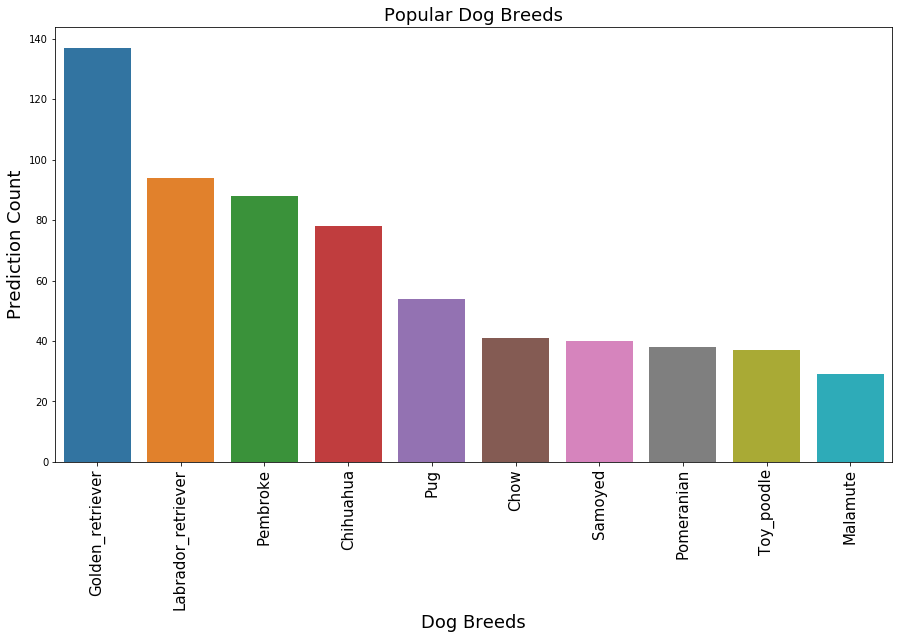

In [107]:
## highest Dog Breeds
plt.figure(figsize = (15,8))
ax = sb.barplot(x = master_clean['first_prediction'].value_counts()[0:10].index,
            y =master_clean['first_prediction'].value_counts()[0:10],
            data = master_clean);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 15);
plt.xlabel("Dog Breeds",fontsize = 18);
plt.ylabel("Prediction Count",fontsize = 18);
plt.title("Popular Dog Breeds",fontsize = 18);

## The Higher Dog have tweets 

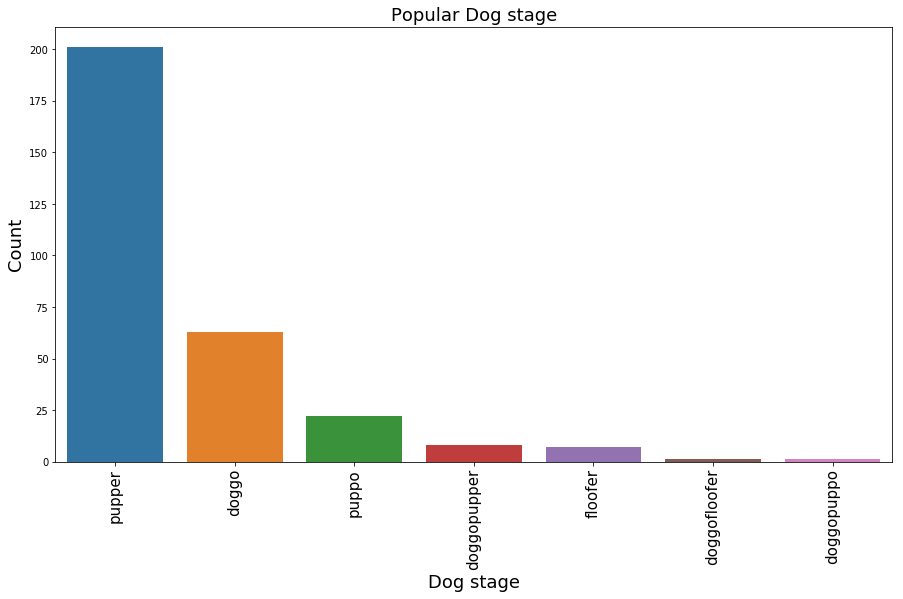

In [108]:
plt.figure(figsize = (15,8))
ax = sb.barplot(x = master_clean['dog_stage'].value_counts()[0:10].index,
            y =master_clean['dog_stage'].value_counts()[0:10],
            data = master_clean);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 15);
plt.xlabel("Dog stage",fontsize = 18);
plt.ylabel("Count",fontsize = 18);
plt.title("Popular Dog stage",fontsize = 18);

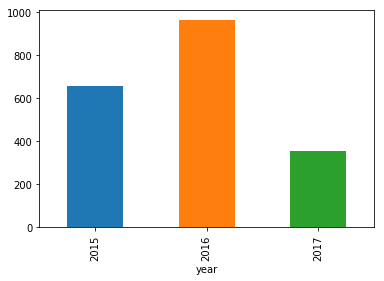

In [110]:
# Twitter user increase in 2016 and decrease in 2017
master_clean.groupby("year")['tweet_id'].count().plot(kind='bar');